# TP 2 - Bag of Words (BOW) & TF-IDF

L'objectif de ce TP est la construction d'un BOW pour la détection de SPAM sur une base de données de mails, puis l'implémentation de TF-IDF.

## Exercice 1 – BOW (Bag of Words)

In [1]:
# 1. Importer les dépendances
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# 2. Importer les données
# On utilise spam.csv qui semble correspondre à la structure attendue (v1, v2)
try:
    df = pd.read_csv('../data/spam.csv', encoding='latin-1')
except FileNotFoundError:
    print("Fichier non trouvé. Vérifiez le chemin.")

# Renommer les colonnes pour plus de clarté si nécessaire, ou garder v1/v2 comem dans le TP
# Le TP utilise v1 (label) et v2 (text)
df = df[['v1', 'v2']]
df.columns = ['label', 'text'] # Renommons pour clarté

print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pierre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pierre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# 3. Prétraitement des données
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

corpus = []
for i in range(len(df)):
    # Supprimer les caractères non alphabétiques
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    
    # Lemmatisation et suppression des stopwords
    review = [lemmatizer.lemmatize(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

# Ajoutons le corpus nettoyé au dataframe pour vérification
df['cleaned_text'] = corpus
print(df.head())

  label                                               text  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4                nah think go usf life around though  


In [3]:
# 4. Implémenter BOW avec sklearn
from sklearn.feature_extraction.text import CountVectorizer

# max_features=2500 signifie qu'on ne garde que les 2500 mots les plus fréquents
# Avantage plus grand : capture plus de nuances, mais risque de sur-apprentissage et coût calculatoire
# Avantage plus petit : modèle plus simple, rapide, moins de bruit, mais perte d'info
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()

# 5. Transformation de la variable cible (label)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['label'])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5572, 2500)
Shape of y: (5572,)


### Question du Chapitre 2 : Que signifie **max_features** ?
Cela force le vecteur à ne garder que les **2500 mots les plus fréquents** du corpus.

**Impact de ce paramètre :**
- **Plus grand (> 2500)** : On garde plus de mots rares. Meilleure précision potentielle, mais matrice plus lourde (mémoire) et risque de sur-apprentissage (bruit).
- **Plus petit (< 2500)** : On ne garde que les mots très courants. Modèle plus rapide et généraliste, mais on risque de perdre des mots-clés importants (ex: "solde", "gratuit" pour le spam).


## Exercice 2 – Modélisation

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
# Experimentation max_features
features_list = [500, 2500, 5000]

for n in features_list:
    print(f"Testing max_features={n}...")
    cv_tmp = CountVectorizer(max_features=n)
    X_tmp = cv_tmp.fit_transform(corpus).toarray()
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tmp, y, test_size=0.2, random_state=42)
    
    model_t = MultinomialNB()
    model_t.fit(X_train_t, y_train_t)
    print(f"Accuracy: {accuracy_score(y_test_t, model_t.predict(X_test_t)):.4f}")


Testing max_features=500...
Accuracy: 0.9767
Testing max_features=2500...
Accuracy: 0.9839
Testing max_features=5000...


Accuracy: 0.9794


In [5]:
# 1. Définition de la base d’apprentissage et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Apprentissage d’un modèle de classification (Teoreme de Bayes)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

# 3. Prédiction et calcul des performances
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)

Confusion Matrix:
 [[957   8]
 [ 10 140]]
Accuracy: 0.9838565022421525


### Observations Basées sur l'Exécution :


## Exercice 3 - TF-IDF

Utilisation de TF-IDF pour pondérer l'importance des termes.

In [6]:
from sklearn.metrics import accuracy_score
# Comparaison avec SVM (Support Vector Machine)
from sklearn.svm import SVC

svm_model = SVC(kernel='linear') # Linear kernel is often best for text
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Naive Bayes Accuracy:", acc)

SVM Accuracy: 0.9802690582959641
Naive Bayes Accuracy: 0.9838565022421525


### Question du Chapitre 2 : Quel autre modèle pourriez-vous proposer ?
Naive Bayes est excellent pour le texte (baseline), mais d'autres modèles sont performants :
1. **SVM (Support Vector Machine)** : Très efficace en haute dimension (comme ici avec 2500 features). Souvent le meilleur en classification de texte classique.
2. **Random Forest / XGBoost** : Peut capturer des interactions non linéaires entre les mots, mais plus lent à entraîner.
3. **Réseaux de Neurones (Deep Learning)** : Comme BERT (voir TP4), qui capture le sens contextuel.


### Comparaison des Modèles :


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# On repart des données brutes pour utiliser le pipeline complet
X_raw = df['text']
y_raw = df['label']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=57)

# Définir une data pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')), # Nettoyage et vectorisation
    ('tfidf', TfidfTransformer()), # TF-IDF
    ('clf', LogisticRegression()), # Classification
])

# Exécuter le pipeline
text_clf.fit(X_train_raw, y_train_raw)

# Prédiction
predicted = text_clf.predict(X_test_raw)

# Imprimer le rapport de performance
print("Accuracy:", accuracy_score(y_test_raw, predicted))
print("Confusion Matrix:\n", confusion_matrix(y_test_raw, predicted))

Accuracy: 0.9695067264573991
Confusion Matrix:
 [[976   3]
 [ 31 105]]


In [8]:
# Validation croisée
from sklearn.model_selection import cross_val_score

scores = cross_val_score(text_clf, X_raw, y_raw, cv=5)
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))

Cross-validation scores: [0.96681614 0.96591928 0.96229803 0.95780969 0.96768402]
Mean score: 0.9641054334962282


In [9]:
# Essayer quelques phrases
examples = [
    'Subscribe to my Youtube Channel!! :)',
    'Hi veronica, hope you are doing good',
    'Earn money for being online with 0 efforts! ...'
]
predictions = text_clf.predict(examples)

for text, label in zip(examples, predictions):
    print(f"'{text}' -> {label}")

'Subscribe to my Youtube Channel!! :)' -> ham
'Hi veronica, hope you are doing good' -> ham
'Earn money for being online with 0 efforts! ...' -> ham


---

# Exercice 3 - Vectorisation de Texte & Similarité Documentaire

Cet exercice explore la vectorisation complète (BOW, N-grams, TF-IDF calculé manuellement)
et la similarité / le clustering de documents.

*Source : TP_NLP_2_other_example.pdf*


In [10]:
# 1-2. Définition du corpus d'exemple
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

corpus = [
    'The sky is blue and beautiful.',
    'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

print(f"Corpus de {len(corpus)} documents, {len(set(labels))} catégories: {set(labels)}")


Corpus de 8 documents, 3 catégories: {'food', 'animals', 'weather'}


In [11]:
# 3-4. Prétraitement du texte
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

corpus_clean = [preprocess(doc) for doc in corpus]

for i, (orig, clean) in enumerate(zip(corpus, corpus_clean)):
    print(f"Doc {i}: {orig}")
    print(f"  -> {clean}")


Doc 0: The sky is blue and beautiful.
  -> sky blue beautiful
Doc 1: Love this blue and beautiful sky!
  -> love blue beautiful sky
Doc 2: The quick brown fox jumps over the lazy dog.
  -> quick brown fox jumps lazy dog
Doc 3: A king's breakfast has sausages, ham, bacon, eggs, toast and beans
  -> kings breakfast sausages ham bacon eggs toast beans
Doc 4: I love green eggs, ham, sausages and bacon!
  -> love green eggs ham sausages bacon
Doc 5: The brown fox is quick and the blue dog is lazy!
  -> brown fox quick blue dog lazy
Doc 6: The sky is very blue and the sky is very beautiful today
  -> sky blue sky beautiful today
Doc 7: The dog is lazy but the brown fox is quick!
  -> dog lazy brown fox quick


### BOW (Bag of Words) - Représentation Fréquentielle


In [12]:
# 5-7. BOW modelling
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
bow_matrix = cv.fit_transform(corpus_clean)

# Vocabulaire
vocab = cv.get_feature_names_out()
print(f"Vocabulaire ({len(vocab)} mots uniques): {list(vocab)}")

# Représentation dense
import pandas as pd
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vocab)
print("\nMatrice BOW (document x mot):")
bow_df


Vocabulaire (20 mots uniques): ['bacon', 'beans', 'beautiful', 'blue', 'breakfast', 'brown', 'dog', 'eggs', 'fox', 'green', 'ham', 'jumps', 'kings', 'lazy', 'love', 'quick', 'sausages', 'sky', 'toast', 'today']

Matrice BOW (document x mot):


,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


In [13]:
# 8. N-gram BOW text representation
cv_bigram = CountVectorizer(ngram_range=(1, 2))
bow_bigram = cv_bigram.fit_transform(corpus_clean)

vocab_bigram = cv_bigram.get_feature_names_out()
print(f"Vocabulaire avec bigrams: {len(vocab_bigram)} features")
print(f"Exemples de bigrams: {[v for v in vocab_bigram if ' ' in v][:10]}")


Vocabulaire avec bigrams: 49 features
Exemples de bigrams: ['bacon eggs', 'beautiful sky', 'beautiful today', 'blue beautiful', 'blue dog', 'blue sky', 'breakfast sausages', 'brown fox', 'dog lazy', 'eggs ham']


### Calcul Manuel de TF-IDF

Au lieu d'utiliser directement `TfidfVectorizer`, calculons TF-IDF **étape par étape** pour comprendre la mécanique interne.


In [14]:
# 9-11. Imports et vocabulaire
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# Vocabulaire dict
vocab_dict = {word: idx for idx, word in enumerate(vocab)}
print(f"Dictionnaire vocabulaire (extrait): {dict(list(vocab_dict.items())[:5])}")

# 12. Document-Word Matrix (BOW fréquences)
bow_array = bow_matrix.toarray()
print(f"\nMatrice Document-Mot: shape = {bow_array.shape}")
print(bow_array)


Dictionnaire vocabulaire (extrait): {'bacon': 0, 'beans': 1, 'beautiful': 2, 'blue': 3, 'breakfast': 4}

Matrice Document-Mot: shape = (8, 20)
[[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0]]


In [15]:
# 13. Document Frequency (DF) : dans combien de documents chaque mot apparaît
df = np.sum(bow_array > 0, axis=0)
print("Document Frequency (DF):")
for word, freq in zip(vocab, df):
    print(f"  {word}: {freq}/{len(corpus)} documents")


Document Frequency (DF):
  bacon: 2/8 documents
  beans: 1/8 documents
  beautiful: 3/8 documents
  blue: 4/8 documents
  breakfast: 1/8 documents
  brown: 3/8 documents
  dog: 3/8 documents
  eggs: 2/8 documents
  fox: 3/8 documents
  green: 1/8 documents
  ham: 2/8 documents
  jumps: 1/8 documents
  kings: 1/8 documents
  lazy: 3/8 documents
  love: 2/8 documents
  quick: 3/8 documents
  sausages: 2/8 documents
  sky: 3/8 documents
  toast: 1/8 documents
  today: 1/8 documents


In [16]:
# 14. Inverse Document Frequency (IDF)
N = len(corpus)
idf = np.log((N + 1) / (df + 1)) + 1  # formule sklearn (smooth)
print("IDF (plus le score est haut, plus le mot est rare/discriminant):")
for word, score in sorted(zip(vocab, idf), key=lambda x: -x[1]):
    print(f"  {word}: {score:.4f}")


IDF (plus le score est haut, plus le mot est rare/discriminant):
  beans: 2.5041
  breakfast: 2.5041
  green: 2.5041
  jumps: 2.5041
  kings: 2.5041
  toast: 2.5041
  today: 2.5041
  bacon: 2.0986
  eggs: 2.0986
  ham: 2.0986
  love: 2.0986
  sausages: 2.0986
  beautiful: 1.8109
  brown: 1.8109
  dog: 1.8109
  fox: 1.8109
  lazy: 1.8109
  quick: 1.8109
  sky: 1.8109
  blue: 1.5878


In [17]:
# 15-16. Raw TF-IDF + L2 Norm
tf_idf_raw = bow_array * idf  # broadcast: chaque ligne x vecteur IDF
print("TF-IDF brut (doc 0):")
print(tf_idf_raw[0])

# L2 norms
l2_norms = np.sqrt(np.sum(tf_idf_raw ** 2, axis=1))
print(f"\nNormes L2: {l2_norms}")


TF-IDF brut (doc 0):
[0.         0.         1.81093022 1.58778666 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.81093022
 0.         0.        ]

Normes L2: [3.01330433 3.67208068 4.76106552 6.53439428 5.31895397 4.3495296
 5.01884562 4.04936307]


In [18]:
# 17. TF-IDF Normalisé (chaque document est un vecteur unitaire)
tf_idf_norm = tf_idf_raw / l2_norms[:, np.newaxis]

tfidf_df = pd.DataFrame(tf_idf_norm, columns=vocab)
print("TF-IDF Normalisé:")
tfidf_df.round(3)


TF-IDF Normalisé:


,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.000,0.000,0.601,0.527,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.601,0.000,0.000
1,0.000,0.000,0.493,0.432,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.572,0.000,0.000,0.493,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.380,0.380,0.000,0.380,0.000,0.000,0.526,0.000,0.380,0.000,0.380,0.000,0.000,0.000,0.000
3,0.321,0.383,0.000,0.000,0.383,0.000,0.000,0.321,0.000,0.000,0.321,0.000,0.383,0.000,0.000,0.000,0.321,0.000,0.383,0.000
4,0.395,0.000,0.000,0.000,0.000,0.000,0.000,0.395,0.000,0.471,0.395,0.000,0.000,0.000,0.395,0.000,0.395,0.000,0.000,0.000
5,0.000,0.000,0.000,0.365,0.000,0.416,0.416,0.000,0.416,0.000,0.000,0.000,0.000,0.416,0.000,0.416,0.000,0.000,0.000,0.000
6,0.000,0.000,0.361,0.316,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.722,0.000,0.499
7,0.000,0.000,0.000,0.000,0.000,0.447,0.447,0.000,0.447,0.000,0.000,0.000,0.000,0.447,0.000,0.447,0.000,0.000,0.000,0.000


In [19]:
# 18. Vérification : comparaison avec sklearn
tfidf_sklearn = TfidfVectorizer()
tfidf_sk_matrix = tfidf_sklearn.fit_transform(corpus_clean).toarray()

# Les résultats doivent être très proches
diff = np.abs(tf_idf_norm - tfidf_sk_matrix).max()
print(f"Différence max entre notre calcul et sklearn: {diff:.10f}")
print("(Si proche de 0, notre implémentation est correcte !)")


Différence max entre notre calcul et sklearn: 0.0000000000
(Si proche de 0, notre implémentation est correcte !)


### Similarité Documentaire & Clustering


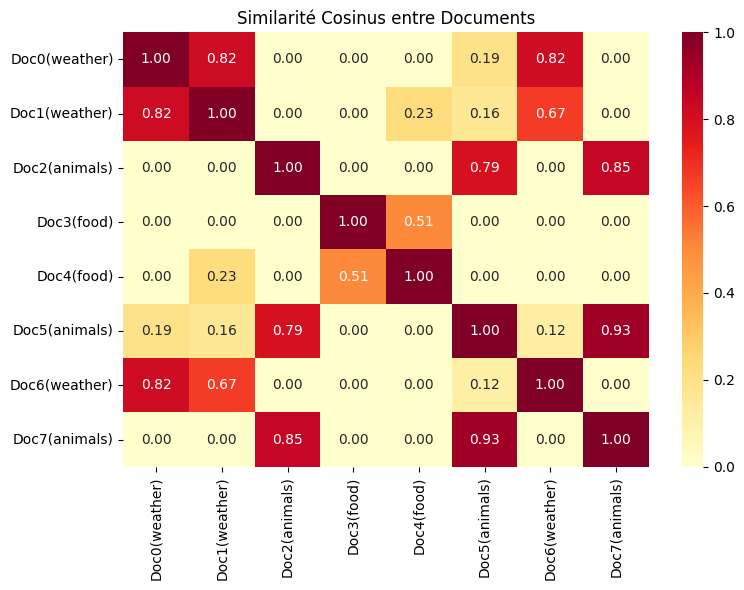

In [20]:
# 19-20. Pairwise similarity (cosinus)
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sim_matrix = cosine_similarity(tf_idf_norm)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, annot=True, fmt='.2f',
            xticklabels=[f'Doc{i}({l})' for i, l in enumerate(labels)],
            yticklabels=[f'Doc{i}({l})' for i, l in enumerate(labels)],
            cmap='YlOrRd')
plt.title('Similarité Cosinus entre Documents')
plt.tight_layout()
plt.show()


**Observation** : Les documents du même thème (weather, animals, food) ont une similarité plus élevée entre eux.
C'est la preuve que TF-IDF capture bien le thème d'un document.


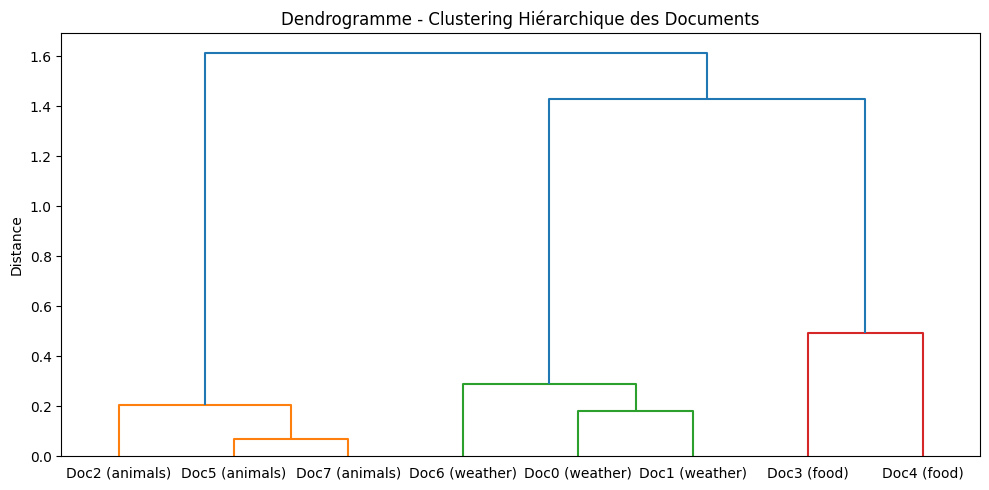

In [21]:
# 21-22. Clustering hiérarchique des documents
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Distance = 1 - similarité cosinus
dist_matrix = 1 - sim_matrix

# Linkage hiérarchique
from scipy.spatial.distance import squareform
np.fill_diagonal(dist_matrix, 0)
condensed_dist = squareform(dist_matrix)
Z = linkage(condensed_dist, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=[f'Doc{i} ({labels[i]})' for i in range(len(corpus))],
           leaf_font_size=10)
plt.title('Dendrogramme - Clustering Hiérarchique des Documents')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


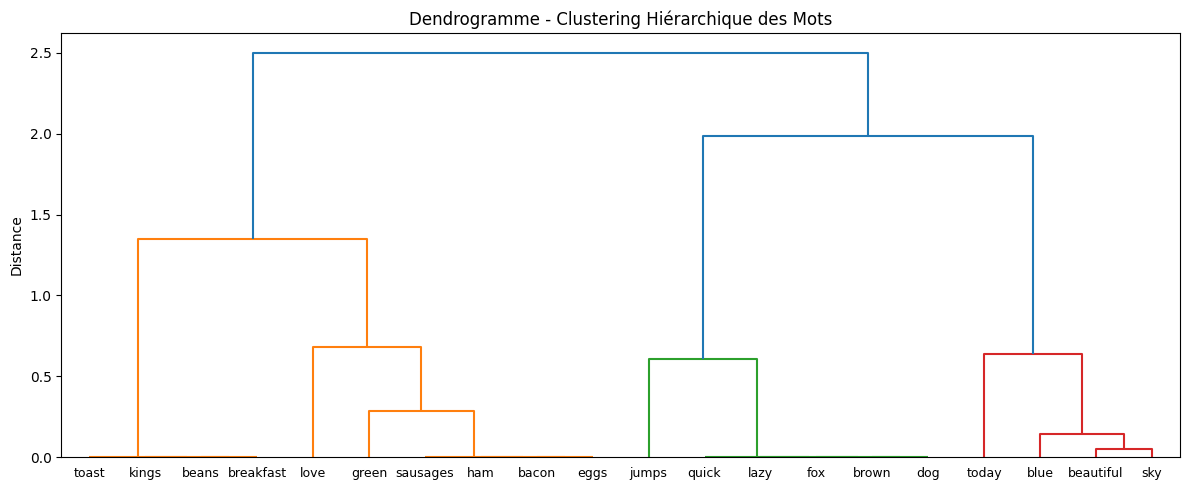

In [22]:
# 23-24. Clustering de mots (par similarité)
word_sim = cosine_similarity(tf_idf_norm.T)  # Transposé : mots x mots

word_dist = 1 - word_sim
np.fill_diagonal(word_dist, 0)
word_dist = np.clip(word_dist, 0, None)  # Pas de distances négatives

condensed_word_dist = squareform(word_dist)
Z_words = linkage(condensed_word_dist, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(Z_words, labels=list(vocab), leaf_font_size=9)
plt.title('Dendrogramme - Clustering Hiérarchique des Mots')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


**Observation** : Le dendrogramme des mots montre que les mots liés thématiquement
(ex: 'sky', 'blue', 'beautiful' pour weather ; 'fox', 'brown', 'lazy', 'dog' pour animals)
se regroupent dans les mêmes branches. Cela confirme que TF-IDF capture la co-occurrence thématique.
